In [1]:
import pynumdiff
import numpy as np
import cvxpy
import matplotlib.pyplot as plt

# Simulate full lorenz system

In [2]:
# Simulation parameters
noise_parameters = [0, 0.00001]
dt = 0.01
timeseries_length = 4

In [3]:
noisy_measurements, actual_vals, extras = pynumdiff.utils.simulate.lorenz_xyz(noise_parameters=noise_parameters,
                                                                              dt=dt,
                                                                              timeseries_length=timeseries_length)
x = noisy_measurements[0,:]
y = noisy_measurements[1,:]
z = noisy_measurements[2,:]

xdot_actual = actual_vals[3,:]
ydot_actual = actual_vals[4,:]
zdot_actual = actual_vals[5,:]

Text(0,0.5,'z')

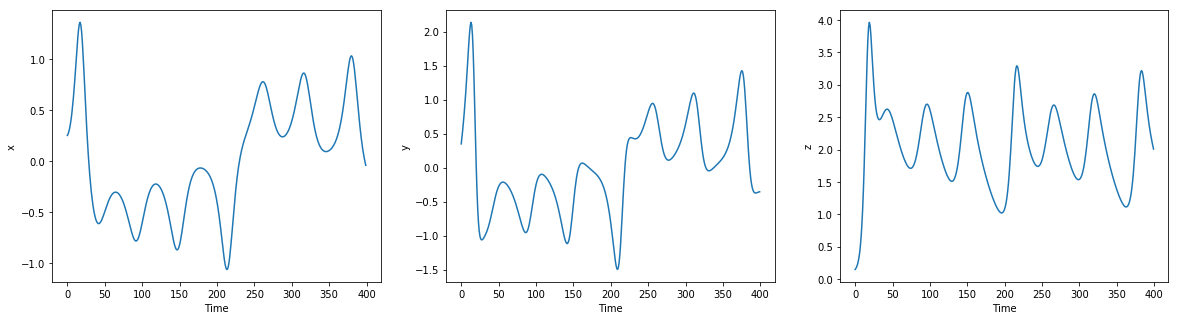

In [4]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(x)
ax.set_xlabel('Time')
ax.set_ylabel('x')

ax = fig.add_subplot(1,3,2)
ax.plot(y)
ax.set_xlabel('Time')
ax.set_ylabel('y')

ax = fig.add_subplot(1,3,3)
ax.plot(z)
ax.set_xlabel('Time')
ax.set_ylabel('z')

# Estimate derivatives

In [59]:
# Derivative estimate parameters
smoothing = 1e-5

In [60]:
x_hat, xdot_hat = pynumdiff.total_variation_regularization.jerk(x, dt=dt, params=[smoothing]) 
y_hat, ydot_hat = pynumdiff.total_variation_regularization.jerk(y, dt=dt, params=[smoothing]) 
z_hat, zdot_hat = pynumdiff.total_variation_regularization.jerk(z, dt=dt, params=[smoothing]) 

Text(0,0.5,'zdot_hat')

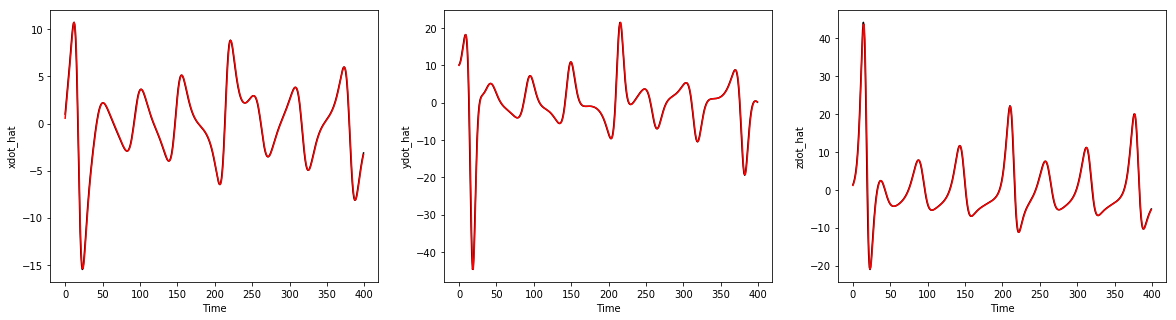

In [61]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(xdot_actual, color='black')
ax.plot(xdot_hat, color='red')
ax.set_xlabel('Time')
ax.set_ylabel('xdot_hat')

ax = fig.add_subplot(1,3,2)
ax.plot(ydot_actual, color='black')
ax.plot(ydot_hat, color='red')
ax.set_xlabel('Time')
ax.set_ylabel('ydot_hat')

ax = fig.add_subplot(1,3,3)
ax.plot(zdot_actual, color='black')
ax.plot(zdot_hat, color='red')
ax.set_xlabel('Time')
ax.set_ylabel('zdot_hat')

# PySINDy

### SINDy requires the user to provide a library of features, which can be nonlinear combinations of the states

In [62]:
def get_library(x, y, z):
    try:
        _ = len(x)
        library = [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, x*y*z, np.ones_like(x)]
    except:
        library = [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, x*y*z, 1]
    return library

### To treat each feature equally in the optimization, we first need to whiten the inputs and the derivatives (e.g. mean=0 / std=1)
We save the whitening parameters so that we can later undo the whitening

In [63]:
class DeWhiten(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def dewhiten(self, m):
        return (m+self.mean)*self.std

In [64]:
def whiten_library(library):
    white_library = []
    dewhiten = []
    for m in library:
        m += 2*(np.random.random(len(m))-0.5)*1e-8 # in case we have a pure constant
        
        std_m = np.std(m)**2
        mean_m = np.mean(m)
        
        white_m = (m-mean_m)/std_m
        white_library.append(white_m)

        dewhiten.append(DeWhiten(mean_m, std_m))
    return white_library, dewhiten

In [65]:
# Features
library = get_library(x, y, z)
white_library, dewhiten_library = whiten_library(library)

# Whitened derivatives
white_states, dewhiten_states = whiten_library([xdot_hat, ydot_hat, zdot_hat])
white_xdot, white_ydot, white_zdot = white_states

### Solve the optimization problem

In [66]:
# Setup convex optimization problem

var = cvxpy.Variable( (3, len(library)) )

sum_squared_error_x = cvxpy.sum_squares( white_xdot - white_library*var[0,:] )
sum_squared_error_y = cvxpy.sum_squares( white_ydot - white_library*var[1,:] )
sum_squared_error_z = cvxpy.sum_squares( white_zdot - white_library*var[2,:] )

sum_squared_error = cvxpy.sum([sum_squared_error_x, 
                               sum_squared_error_y, 
                               sum_squared_error_z])

In [74]:
# Optimization parameters
gamma = 1
solver = 'MOSEK'

In [75]:
# Solve convex optimization problem
L = cvxpy.sum( sum_squared_error + gamma*cvxpy.norm1(var) )
obj = cvxpy.Minimize(L)
prob = cvxpy.Problem(obj)
r = prob.solve(solver=solver)
sindy_coefficients = var.value

In [76]:
sindy_coefficients

array([[-1.65875933e-01,  2.50881698e-01, -3.81342217e-10,
         1.38123682e-03, -1.02399056e-03,  1.04701620e-11,
        -6.60468153e-09,  3.97253257e-10,  4.18563272e-02,
        -1.35745353e-10,  2.39704546e-12],
       [ 1.52577172e-01,  1.72115284e-02,  4.22650718e-05,
        -2.42285195e-03,  4.85780617e-03,  1.55329694e-10,
         1.77915816e-04, -5.10134102e-01, -5.52639749e-10,
         4.23655520e-10, -1.81069128e-12],
       [ 5.54878014e-10,  8.03039780e-10, -1.46300384e-02,
         4.38013804e-03, -3.06976361e-03, -1.20302091e-10,
         4.65628430e-02,  3.82774007e-10,  7.21722898e-10,
         3.60811979e-03,  2.85067004e-12]])

### Now we undo the whitening

In [77]:
# dewhiten library coefficients

library_std = []
library_mean = []
for d in dewhiten_library:
    library_std.append(d.std)
    library_mean.append(d.mean)
library_std = np.array(library_std)
library_mean = np.array(library_mean)

In [78]:
# dewhiten state coefficients

state_std = []
state_mean = []
for d in dewhiten_states:
    state_std.append(d.std)
    state_mean.append(d.mean)
state_std = np.array(state_std)
state_mean = np.array(state_mean)

In [79]:
dewhitened_sindy_coefficients = sindy_coefficients/library_std
library_offset = np.matrix(dewhitened_sindy_coefficients[:,:])*np.matrix(library_mean).T

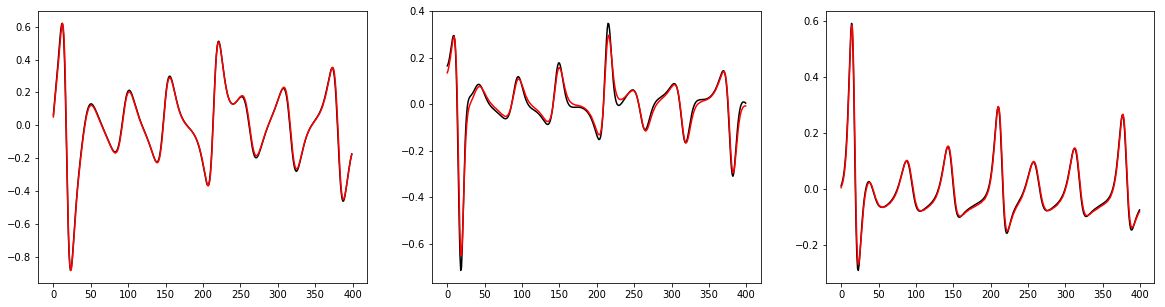

In [80]:
# Compare reconstructed derivatives to whitened derivatives

# Whitened actual states
white_xdot_states, dewhiten_states = whiten_library([xdot_actual, ydot_actual, zdot_actual])
white_xdot_actual, white_ydot_actual, white_zdot_actual = white_xdot_states

fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    white_sdot_rec = np.matrix(dewhitened_sindy_coefficients[i,:])*np.matrix(library) - library_offset[i]
    
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval('white_' + i_to_s[i] + 'dot_actual'), color='black')
    ax.plot(white_sdot_rec.T, color='red')

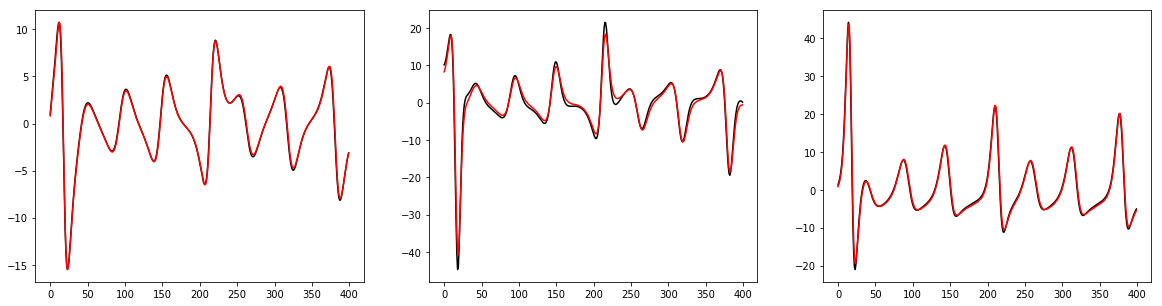

In [81]:
# Compare reconstructed derivatives to actual derivatives

fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    white_sdot_rec = np.matrix(dewhitened_sindy_coefficients[i,:])*np.matrix(library) - library_offset[i]
    sdot_rec = white_sdot_rec*state_std[i] + state_mean[i]
    
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval(i_to_s[i] + 'dot_actual'), color='black')
    ax.plot(sdot_rec.T, color='red')

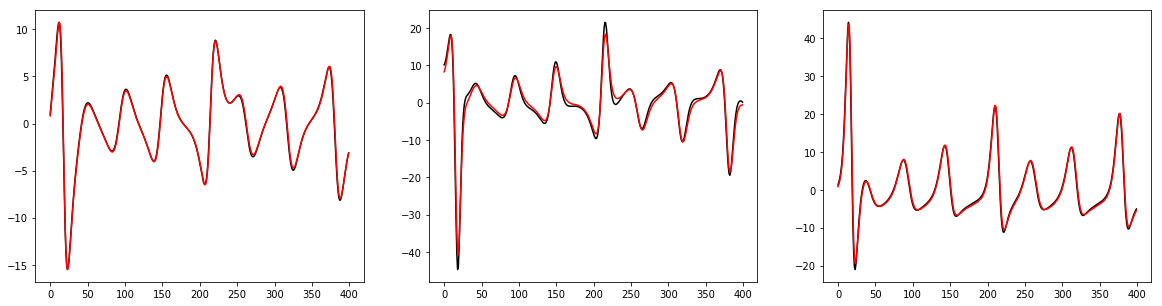

In [82]:
# Put everything together

estimated_coefficients = sindy_coefficients/library_std*np.tile(state_std, [len(library), 1]).T
offset = -1*(state_std*np.ravel(library_offset)) + state_mean

fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    sdot_rec = np.matrix(estimated_coefficients[i,:])*np.matrix(library) + offset[i]
    
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval(i_to_s[i] + 'dot_actual'), color='black')
    ax.plot(sdot_rec.T, color='red')

In [83]:
estimated_coefficients

array([[-9.68750671e+00,  9.27733308e+00, -1.59999025e-08,
         2.23223651e-01, -3.84115830e-02,  2.50282711e-11,
        -6.18658695e-07,  3.47186233e-09,  3.25298977e-01,
        -1.91563833e-09,  1.38872935e+06],
       [ 3.18767449e+01,  2.27682356e+00,  6.34365900e-03,
        -1.40073089e+00,  6.51871813e-01,  1.32827410e-09,
         5.96169241e-02, -1.59490623e+01, -1.53645367e-08,
         2.13873603e-08, -3.75267992e+06],
       [ 1.37481029e-07,  1.25981811e-07, -2.60414124e+00,
         3.00314621e+00, -4.88526137e-01, -1.22002082e-09,
         1.85035624e+01,  1.41923426e-08,  2.37962588e-08,
         2.16016097e-01,  7.00656113e+06]])

# Open loop simulation

In [528]:
simdt=0.0001

x0 = actual_vals[0,0]
y0 = actual_vals[1,0]
z0 = actual_vals[2,0]

x_predicted = [x0]
y_predicted = [y0]
z_predicted = [z0]
for i in range(int(len(x)*dt/simdt)):
    library = get_library(x_predicted[-1], y_predicted[-1], z_predicted[-1])
    xdot = np.matrix(estimated_coefficients[0,:])*np.matrix(np.array(library)).T + offset[0]
    x_predicted.append(x_predicted[-1]+xdot[0,0]*simdt)
    
    ydot = np.matrix(estimated_coefficients[1,:])*np.matrix(np.array(library)).T + offset[1]
    y_predicted.append(y_predicted[-1]+ydot[0,0]*simdt)
    
    zdot = np.matrix(estimated_coefficients[2,:])*np.matrix(np.array(library)).T + offset[2]
    z_predicted.append(z_predicted[-1]+zdot[0,0]*simdt)
    
x_predicted = np.array(x_predicted)
y_predicted = np.array(y_predicted)
z_predicted = np.array(z_predicted)

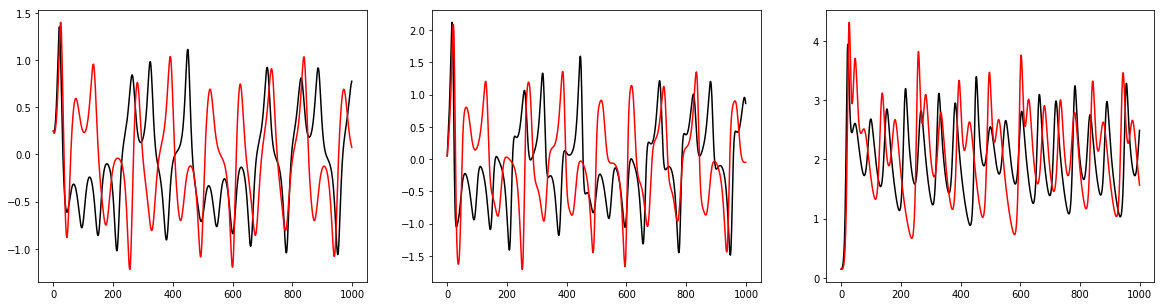

In [529]:
# Put everything together

idx = np.arange(0, len(x)*dt/simdt, int(dt/simdt)).astype(int)

fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval(i_to_s[i]), color='black')
    ax.plot(eval(i_to_s[i]+'_predicted')[idx], color='red')

In [23]:
estimated_coefficients

array([[-9.48207623e+00,  9.51568104e+00,  2.91587582e-03,
         1.23391851e-01],
       [-1.27159331e+01,  2.42297851e+01, -5.81314577e-01,
        -7.53382288e+00],
       [-3.09969665e-07,  7.46400070e-01,  2.07362314e-01,
         6.67978859e-07]])